<a href="https://colab.research.google.com/github/huyng26/LLM_Learning/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
print(train_data)

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [5]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [7]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length" : length}

In [8]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [10]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size = test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [11]:
print(f"Train data: {len(train_data)}")
print(f"Valid data: {len(valid_data)}")
print(f"Test data: {len(test_data)}")

Train data: 14062
Valid data: 4688
Test data: 25000


In [13]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq = min_freq,
    specials = special_tokens
)

In [14]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
print(f"Unk index: {unk_index}, Pad index: {pad_index}")

Unk index: 0, Pad index: 1


In [15]:
vocab.set_default_index(unk_index)

In [16]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [17]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/14062 [00:00<?, ? examples/s]

Map:   0%|          | 0/4688 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [18]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [19]:
train_data[0]

{'label': tensor(0),
 'length': tensor(197),
 'ids': tensor([   12,     9,   149,   138,   277,     8,   865,    54,    52,    46,
            17,     5,   243,     8,    14,    23,     3,    21,  1492,    15,
             9,    16,   436,     8,    34,    43,     9,  5399,     9,     6,
             9,  2783,     9,     2,   199,    15, 15797,     0,     8,     2,
          1410,    30,  5022,   785,     3,  1410,   319,     8,    34,   765,
         13560,    40,  3201,     0,  8801,     6,  8094,     7,   700,     0,
             0,  1717,     0,     3,  4968,     4,  1413,     3,    12,  1346,
            11,    67,    31,    88,   111,    84,     8,   916,     8,    31,
             5,  1489,  6709,    23,   129,     5,   366,  1017,  8514,   171,
             9,    26,    87,   274,   141,     3,   701,     5,     9,   662,
           557,    69,    27,     2,  2248,  5464,     9,    10,     5,   557,
            15,  3084,     7,   118,    83,     3,   109,  3099,   319,     8,


In [21]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value = pad_index, batch_first= True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [23]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        collate_fn = collate_fn,
        shuffle = shuffle
    )
    return data_loader

In [24]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [58]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
           embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [59]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 9,175,802 trainable parameters


In [61]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [62]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(18550, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [63]:
vectors = torchtext.vocab.GloVe()

In [64]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [65]:
print(vocab.get_stoi())

{'zulu': 18548, 'zhu': 18547, 'youssef': 18540, 'yankee': 18532, 'yam': 18531, 'yahoo': 18530, 'x-rated': 18529, 'wynn': 18528, 'ww1': 18527, 'wuhl': 18526, 'wreckage': 18523, 'wove': 18521, 'workings': 18519, 'wince': 18513, 'wilford': 18510, 'wiley': 18509, 'wide-eyed': 18508, 'whiz': 18507, 'whimper': 18505, 'whew': 18504, 'what-so-ever': 18503, 'whales': 18502, 'westerners': 18501, 'welsh': 18499, 'wegener': 18494, 'watergate': 18491, 'warwick': 18489, 'wade': 18484, 'vitality': 18477, 'vistas': 18476, 'virtuous': 18475, 'vil': 18474, 'vierde': 18472, 'vibes': 18471, 'vendor': 18468, 'vendetta': 18467, 'veiled': 18466, 'vegetables': 18465, 'vanishes': 18463, 'valientes': 18462, 'valiant': 18461, 'vaccaro': 18458, 'urinating': 18456, 'uriah': 18455, 'uranium': 18453, 'uproar': 18452, 'unwarranted': 18449, 'unsurpassed': 18447, 'unrestrained': 18444, 'unrequited': 18443, 'unrelenting': 18442, 'unprecedented': 18439, 'unmotivated': 18434, 'unmistakably': 18433, 'unknowingly': 18431, '

In [66]:
print(len(vocab))
print(pretrained_embedding.shape)

18550
torch.Size([18550, 300])


In [67]:
model.embedding.weight.data = pretrained_embedding

In [68]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr = lr)

In [69]:
criterion = nn.CrossEntropyLoss()

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [71]:
model = model.to(device)
criterion = criterion.to(device)

In [72]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [73]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [74]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [75]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch: 0
train_loss: 0.648, train_acc: 0.606
valid_loss: 0.563, valid_acc: 0.707


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch: 1
train_loss: 0.553, train_acc: 0.714
valid_loss: 0.522, valid_acc: 0.748


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


epoch: 2
train_loss: 0.440, train_acc: 0.800
valid_loss: 0.468, valid_acc: 0.810


evaluating...: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch: 3
train_loss: 0.373, train_acc: 0.836
valid_loss: 0.451, valid_acc: 0.827


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch: 4
train_loss: 0.343, train_acc: 0.854
valid_loss: 0.471, valid_acc: 0.825


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch: 5
train_loss: 0.327, train_acc: 0.862
valid_loss: 0.362, valid_acc: 0.843


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch: 6
train_loss: 0.295, train_acc: 0.879
valid_loss: 0.473, valid_acc: 0.847


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch: 7
train_loss: 0.258, train_acc: 0.896
valid_loss: 0.390, valid_acc: 0.861


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch: 8
train_loss: 0.228, train_acc: 0.908
valid_loss: 0.394, valid_acc: 0.868


evaluating...: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

epoch: 9
train_loss: 0.219, train_acc: 0.916
valid_loss: 0.336, valid_acc: 0.872


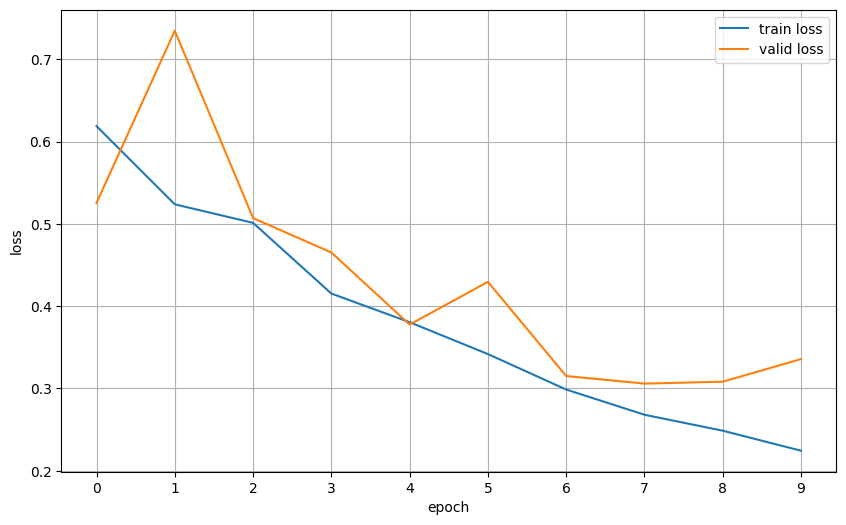

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

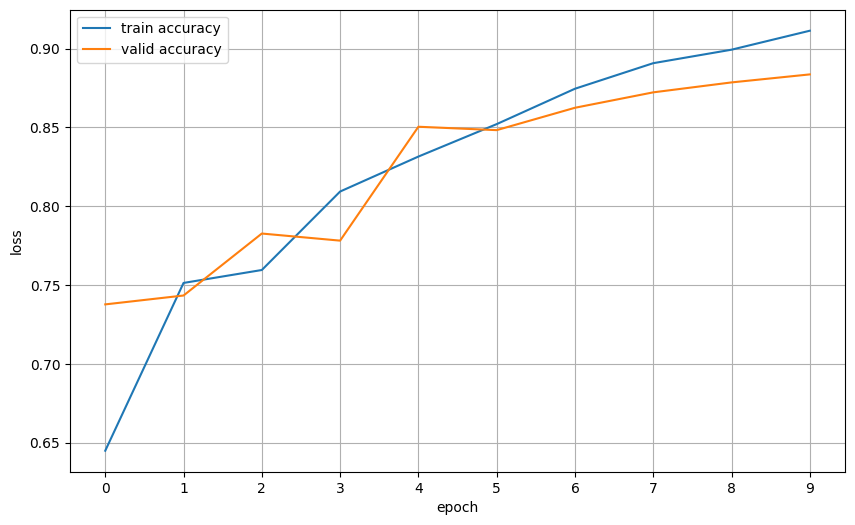

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|████████████████████████████| 49/49 [00:03<00:00, 15.55it/s]


In [ ]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.327, test_acc: 0.862


In [ ]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability
    #Single input → Add batch dimension → Model processing → Remove batch dimension → Single output

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9134657382965088)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9098743200302124)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.7186734676361084)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.6654170155525208)